# 04 - Underwriting Workflow

In [1]:
import os
from dotenv import load_dotenv

# Step 1: Load environment variables from .env file
load_dotenv()

# Step 2: Retrieve Azure OpenAI environment variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
OPENAI_API_VERSION = os.getenv("OPENAI_API_VERSION")

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",  # Your Azure deployment
    api_version=OPENAI_API_VERSION,  # Your API version
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [2]:
from typing import Optional
from pydantic import BaseModel, Field

#input 
class ApplicantInfo(BaseModel):
    """Information about the insurance applicant."""
    age: str 
    home_value: str 
    home_type: str 
    home_location: str 
    natural_disaster_risk: str 
    building_material: str 
    construction_year: str 
    employment_status: str 
    annual_income: str

#output
class UnderwritingDecision(BaseModel):
    """Underwriting decision for the applicant."""
    approved: bool
    premium: Optional[float] = None
    notes: Optional[str] = Field(description="Summary Decision")

In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
#state
class UnderwritingState(TypedDict):
    applicant_info: ApplicantInfo
    evaluate_info : dict 
    premium_calculation : dict
    underwriting_decision: Optional[UnderwritingDecision]

graph_builder = StateGraph(UnderwritingState)

In [4]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Define the updated risk assessment prompt with more detailed factors
risk_assessment_prompt = """
You are a home risk assessment expert who calculates a risk score based on the applicant's details. 
Please calculate the risk score based on the following factors:

1. **Age**:
- 25-30 years: +0.5
- 30-40 years: +1  
- 40-50 years: +2  
- 50+ years: +3  

2. **Home Location**:  
- High-risk areas (e.g., flood zones, earthquake-prone areas): +4  
- Moderate-risk areas (e.g., urban centers, near rivers): +2  
- Low-risk areas (e.g., safe zones with no history of natural disasters): +1  

3. **Home Value**:  
- Home value over 10,000,000 THB: +3  
- Home value between 5,000,000-10,000,000 THB: +2  
- Home value below 5,000,000 THB: +1  

4. **Home Type**:  
- Condo: +1  
- Detached House: +2  
- Apartment: +1  

5. **Building Material**:  
- Concrete or Steel: +1  
- Wood or Other flammable materials: +3  

6. **Construction Year**:  
- Built before 1980: +3  
- Built between 1980-2000: +2  
- Built after 2000: +1  

7. **Natural Disaster Risk**:  
- High risk (flood, earthquake, etc.): +3  
- Moderate risk: +2  
- Low risk: +1  

8. **Employment Status**:  
- Employed: +1  
- Self-employed: +2  
- Unemployed: +3  

9. **Annual Income**:  
- Over 100,000 THB: +1  
- Between 50,000-100,000 THB: +2  
- Below 50,000 THB: +3  

**Final Calculation**:  
- Add the risk points from each category to get the final risk score. The higher the score, the higher the risk.

User information :
- Age: {age}
- Home Value: {home_value}
- Home Type: {home_type}
- Location: {home_location}
- Disaster Risk: {natural_disaster_risk}
- Building Material: {building_material}
- Construction Year: {construction_year}
- Employment Status: {employment_status} 
- Annual Come: {annual_income} 

Return a JSON object matching OutcomeApplicantInfo schema.
{format_instructions}
"""

# Define the data structure for applicant information.
class OutcomeApplicantInfo(BaseModel):
    reasoning : str = Field(description="Provide details of calculation")
    risk_score: Optional[float] = Field(description="Total risk score")

# Set up the JsonOutputParser and the prompt template.
parser = JsonOutputParser(pydantic_object=OutcomeApplicantInfo)

# Create the prompt template
risk_assessment_prompt = PromptTemplate(
    input_variables=['age','home_value','home_type','home_location','natural_disaster_risk','building_material','construction_year','employment_status','annual_income'],
    template=risk_assessment_prompt,
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Use LangChain to generate the risk assessment
llm_risk = risk_assessment_prompt | llm | parser

def evaluate_risk(state: UnderwritingState):
    print('--evaluate_risk using LLM--')
    #CODE HERE
    
    result = llm_risk.invoke({
        'age': state['applicant_info']['age'],
        'home_value': state['applicant_info']['home_value'],
        'home_type': state['applicant_info']['home_type'],
        'home_location': state['applicant_info']['home_location'],
        'natural_disaster_risk': state['applicant_info']['natural_disaster_risk'],
        'building_material': state['applicant_info']['building_material'],
        'construction_year': state['applicant_info']['construction_year'],
        'employment_status': state['applicant_info']['employment_status'],
        'annual_income': state['applicant_info']['annual_income']
    })
    state['evaluate_info'] = result 
    return state

In [5]:
# # Sample applicant information
# applicant_info = {
#     'name': "Jane Doe",
#     'age': 30,
#     'home_value': 5000000.0,  # Estimated value of the home in Thai Baht
#     'home_type': "Condo",
#     'home_location': "Thonglor, Bangkok, Thailand",
#     'natural_disaster_risk': "Low",
#     'building_material': "Concrete",
#     'construction_year': 2018,
#     'employment_status': "Employed",
#     'annual_income': 60000.0
# }


# llm_risk.invoke(applicant_info)

In [6]:
# Define the data structure for applicant information.
class OutcomePremiumInfo(BaseModel):
    reasoning : str = Field(description="Provide details of calculation")
    final_premium: float = Field(description="Final premium price")

# Set up the JsonOutputParser and the prompt template.
parser = JsonOutputParser(pydantic_object=OutcomePremiumInfo)

premium_template = """
You are a mathematician who specializes in insurance pricing and premium calculations. 
Your task is to calculate the premium price based on an applicant's risk score.

Applicant's risk score : {risk_score}
Base Premium : {base_premium}
premium = base premium * (1 + risk score * 0.1)

Return a JSON object matching OutcomePremiumInfo schema.
{format_instructions}
"""

# Create the prompt template
premium_prompt = PromptTemplate(
    input_variables=['risk_score','base_premium'],
    template=premium_template,
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Use LangChain to generate the risk assessment
llm_premium = premium_prompt | llm | parser

def determine_premium(state: UnderwritingState):
    print('--determine_premium--')
    #CODE HERE
    base_premium = "500" #assume
    result = llm_premium.invoke({
        "risk_score":state["evaluate_info"]['risk_score'], 
        "base_premium": base_premium
    })
    state["premium_calculation"] = result
    return state

In [7]:
# # Sample applicant information
# score_info = {
#     'reasoning': 'Calculated risk score based on the following factors: Age (30 years: +1), Home Location (Moderate-risk area: +2), Home Value (5,000,000 THB: +2), Home Type (Condo: +1), Building Material (Concrete: +1), Construction Year (Built after 2000: +1), Natural Disaster Risk (Low risk: +1), Employment Status (Employed: +1), Annual Income (60,000 THB: +2). Total score = 1 + 2 + 2 + 1 + 1 + 1 + 1 + 1 + 2 = 12.',
#     'risk_score': 12
# }
# base_premium = "500"
# llm_premium.invoke({
#     "risk_score":score_info['risk_score'], 
#     "base_premium": base_premium
# })

In [8]:
# Set up the JsonOutputParser and the prompt template.
parser = JsonOutputParser(pydantic_object=UnderwritingDecision)

decision_template = """
You are a risk assessment expert who calculates and verifies the premium based on the applicant's details.
Given the following inputs:
Premium Product : {premium}
Annual income of customer : {annual_income}

The applicant's monthly income is calculated as: `annual_income / 12`.
If the **premium** is greater than 50% of the **monthly income**, the **approved** field should be set to **false**. Otherwise, it will be set to **true**.

Return a JSON object matching OutcomePremiumInfo schema.
{format_instructions}
"""

# Create the prompt template
decision_prompt = PromptTemplate(
    input_variables=['premium','annual_income'],
    template=decision_template,
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Use LangChain to generate the risk assessment
llm_decision = decision_prompt | llm | parser

In [9]:
# llm_decision.invoke({
#     "premium" : "1100", 
#     "annual_income" : "60000"
# })

In [10]:
def finalize_decision(state: UnderwritingState):
    print('--finalize_decision--')
    #CODE HERE
    result = llm_decision.invoke({"premium" : state["premium_calculation"]['final_premium'], "annual_income" : state["applicant_info"]['annual_income']})
    state['underwriting_decision'] = result
    return state

In [11]:
graph_builder.add_node("evaluate_risk", evaluate_risk)
graph_builder.add_node("determine_premium", determine_premium)
graph_builder.add_node("finalize_decision", finalize_decision)

graph_builder.add_edge(START,"evaluate_risk")
graph_builder.add_edge("evaluate_risk","determine_premium")
graph_builder.add_edge("determine_premium","finalize_decision")
graph_builder.add_edge("finalize_decision", END)

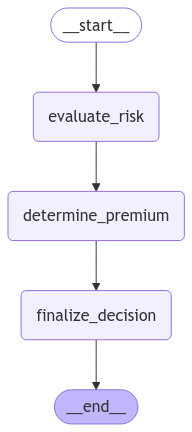

In [12]:
from IPython.display import Image, display

# Compile the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# Sample applicant information
applicant_info = {
    'name': "Jane Doe",
    'age': 30,
    'home_value': 5000000.0,  # Estimated value of the home in Thai Baht
    'home_type': "Condo",
    'home_location': "Thonglor, Bangkok, Thailand",
    'natural_disaster_risk': "Low",
    'building_material': "Concrete",
    'construction_year': 2018,
    'employment_status': "Employed",
    'annual_income': 60000.0
}

# Run the workflow
underwriting_decision = graph.invoke({"applicant_info":applicant_info})
print(underwriting_decision)

--evaluate_risk using LLM--
--determine_premium--
--finalize_decision--
{'applicant_info': {'name': 'Jane Doe', 'age': 30, 'home_value': 5000000.0, 'home_type': 'Condo', 'home_location': 'Thonglor, Bangkok, Thailand', 'natural_disaster_risk': 'Low', 'building_material': 'Concrete', 'construction_year': 2018, 'employment_status': 'Employed', 'annual_income': 60000.0}, 'evaluate_info': {'reasoning': 'Calculated risk score based on the following factors: Age (30 years): +1, Home Location (Thonglor, Bangkok): +2, Home Value (5,000,000 THB): +2, Home Type (Condo): +1, Building Material (Concrete): +1, Construction Year (2018): +1, Natural Disaster Risk (Low): +1, Employment Status (Employed): +1, Annual Income (60,000 THB): +2. Total risk score = 1 + 2 + 2 + 1 + 1 + 1 + 1 + 1 + 2 = 12.', 'risk_score': 12}, 'premium_calculation': {'reasoning': 'The premium is calculated using the formula: premium = base premium * (1 + risk score * 0.1). With a base premium of 500 and a risk score of 12, the 

In [14]:
# underwriting_decision

{'applicant_info': {'name': 'Jane Doe',
  'age': 30,
  'home_value': 5000000.0,
  'home_type': 'Condo',
  'home_location': 'Thonglor, Bangkok, Thailand',
  'natural_disaster_risk': 'Low',
  'building_material': 'Concrete',
  'construction_year': 2018,
  'employment_status': 'Employed',
  'annual_income': 60000.0},
 'evaluate_info': {'reasoning': 'Calculated risk score based on the following factors: Age (30 years): +1, Home Location (Thonglor, Bangkok): +2, Home Value (5,000,000 THB): +2, Home Type (Condo): +1, Building Material (Concrete): +1, Construction Year (2018): +1, Natural Disaster Risk (Low): +1, Employment Status (Employed): +1, Annual Income (60,000 THB): +2. Total risk score = 1 + 2 + 2 + 1 + 1 + 1 + 1 + 1 + 2 = 12.',
  'risk_score': 12},
 'premium_calculation': {'reasoning': 'The premium is calculated using the formula: premium = base premium * (1 + risk score * 0.1). With a base premium of 500 and a risk score of 12, the calculation is 500 * (1 + 12 * 0.1) = 500 * 2.2 = 